# Séries Temporelles


Importons les bibliothèques nécécessaires

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA 
from pandas.plotting import register_matplotlib_converters

In [2]:
register_matplotlib_converters()

importons le jeu de données

In [3]:
#import du le dataset
crimes = pd.read_csv(r'C:\Users\gaman\OneDrive - baudoin\Bureau\serie temporelle\BPD_Part_1_Victim_Based_Crime_Data.csv')

In [4]:
crimes.head(-5)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Location 1,Total Incidents
0,11/12/2016,02:35:00,3B,300 SAINT PAUL PL,ROBBERY - STREET,O,NaN,111.0,CENTRAL,Downtown,"(39.2924100000, -76.6140800000)",1
1,11/12/2016,02:56:00,3CF,800 S BROADWAY,ROBBERY - COMMERCIAL,I,FIREARM,213.0,SOUTHEASTERN,Fells Point,"(39.2824200000, -76.5928800000)",1
2,11/12/2016,03:00:00,6D,1500 PENTWOOD RD,LARCENY FROM AUTO,O,NaN,413.0,NORTHEASTERN,Stonewood-Pentwood-Winston,"(39.3480500000, -76.5883400000)",1
3,11/12/2016,03:00:00,6D,6600 MILTON LN,LARCENY FROM AUTO,O,NaN,424.0,NORTHEASTERN,Westfield,"(39.3626300000, -76.5516100000)",1
4,11/12/2016,03:00:00,6E,300 W BALTIMORE ST,LARCENY,O,NaN,111.0,CENTRAL,Downtown,"(39.2893800000, -76.6197100000)",1
...,...,...,...,...,...,...,...,...,...,...,...,...
285797,01/01/2011,22:00:00,6D,200 EMORY ST,LARCENY FROM AUTO,O,NaN,941.0,SOUTHERN,Ridgely's Delight,"(39.2861000000, -76.6247400000)",1
285798,01/01/2011,22:00:00,6D,1200 N CALHOUN ST,LARCENY FROM AUTO,O,NaN,743.0,WESTERN,Sandtown-Winchester,"(39.3025800000, -76.6403600000)",1
285799,01/01/2011,22:00:00,4E,2700 ASHLAND AV,COMMON ASSAULT,O,HANDS,323.0,EASTERN,Madison-Eastend,"(39.3010900000, -76.5788000000)",1
285800,01/01/2011,22:00:00,5A,2300 BOSTON ST,BURGLARY,I,NaN,232.0,SOUTHEASTERN,Canton,"(39.2828600000, -76.5842000000)",1


filtrons notre dataset

In [5]:
crime2 = crimes[["CrimeDate", "CrimeTime", "Total Incidents", "Weapon"]]
crime2.head()

,CrimeDate,CrimeTime,Total Incidents,Weapon
0,11/12/2016,02:35:00,1,NaN
1,11/12/2016,02:56:00,1,FIREARM
2,11/12/2016,03:00:00,1,NaN
3,11/12/2016,03:00:00,1,NaN
4,11/12/2016,03:00:00,1,NaN


array([[<AxesSubplot:title={'center':'Total Incidents'}>]], dtype=object)

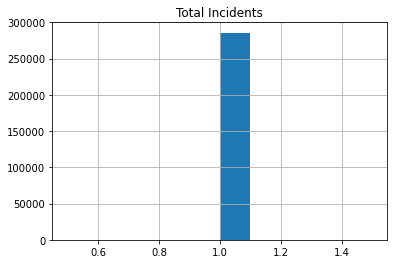

In [6]:
crime2.hist(column='Total Incidents', bins=10)

Regroupons les crimes par date

In [7]:
crime_date = crime2.groupby(['CrimeDate']).sum()
crime_date.head(-5)


,Total Incidents
CrimeDate,
01/01/2011,185
01/01/2012,176
01/01/2013,157
01/01/2014,139
01/01/2015,157
...,...
12/30/2011,130
12/30/2012,116
12/30/2013,121


<function matplotlib.pyplot.show(close=None, block=None)>

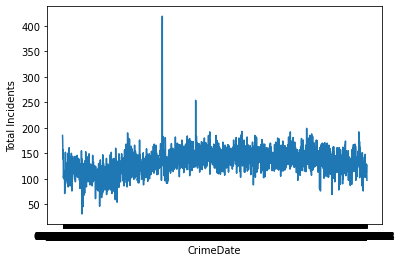

In [8]:
# Visualisons le nombres d'incident par date
plt.xlabel('CrimeDate')
plt.ylabel('Total Incidents')
plt.plot(crime_date)
plt.show

Remarques:
    Baisse progressive du nombre de crimes par jour
    on observe un pick à un peu plus de 400 crimes en une journée
    et un minimum à moin de 50 crimes dans une journée

Groupons les crimes par heures 

In [9]:
crime_heure = crime2.groupby(['CrimeTime']).sum()
crime_heure.head(-5)

,Total Incidents
CrimeTime,
0000,2
0001,2
0002,7
0003,9
0004,4
...,...
23:56:00,67
23:56:18,1
23:57:00,63


<function matplotlib.pyplot.show(close=None, block=None)>

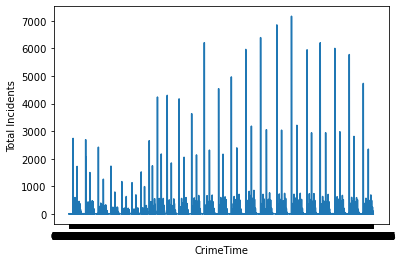

In [10]:
# Visualisons le nombre d'incident par Heure
plt.xlabel('CrimeTime')
plt.ylabel('Total Incidents')
plt.plot(crime_heure)
plt.show

Determinons le type d'arme le plus utilisé

<AxesSubplot:ylabel='Weapon'>

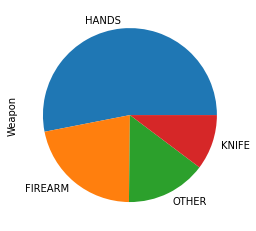

In [20]:
crime2['Weapon'].value_counts().plot(kind='pie')

Les mains semblent être le type d'arme le plus utilisé pour les crimes 

# déterminer si notre série est stationnaire ou non 
Deux façons principales 
1- Statistiques roulantes:
    Tracer la moyenne mobile 
    Tracer l'écart-type mobile
    ==> deux droites parallèle avec l'axe des x 
2- Test de Dickey-Fuller augmenté (ADF)
    Calculer la valeur p
    si p est faible ==> stationnaire 
    si les valeurs critiques à des intervalles de confiance
    de 1%, 5%, 10% sont aussi proches que possible
    des statistiques de l'ADF (Augmented Dickey-Fuller)
    

# Statistiques Roulantes

In [11]:
crime_heure.describe()


,Total Incidents
count,4236.000000
mean,67.470963
std,399.336656
min,1.000000
25%,1.000000
50%,2.000000
75%,30.000000
max,7167.000000


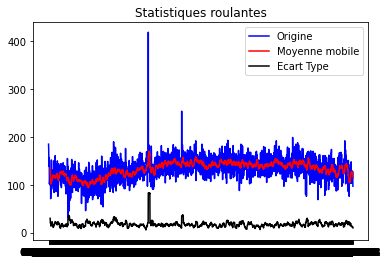

In [12]:
#calculons la moyenne roulante pour notre crimes
rolling_mean = crime_date.rolling(window= 12).mean()
# calculons l'écart type roulant pour notre dataset
rolling_std = crime_date.rolling(window=12).std()
#visualisons les statisques roulantes

plt.plot(crime_date, color='blue', label='Origine')
plt.plot(rolling_mean, color='red', label='Moyenne mobile')
plt.plot(rolling_std, color='black', label='Ecart Type')

plt.legend(loc='best')
plt.title('Statistiques roulantes')
plt.show()


la moyenne mobile semble ne pas augmenter avec le temps 
l'écart type semble constante dans le temps
==> la série temporelle semble stationnaire 

# ADF

In [13]:
result = adfuller(crime_date)
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -2.6610332253224738
p-value : 0.08102732622550052
Valeurs Critiques :
	1%: -3.433442700457683
	5%: -2.8629062300113994
	10%: -2.567497315483069


Statisitques ADF proche des valeurs critiques 
  ==> La série est donc stationnaire 

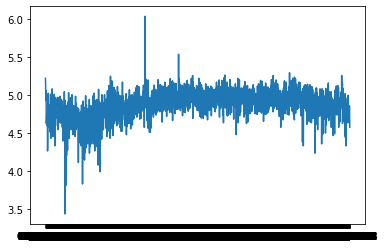

,Total Incidents
CrimeDate,
01/01/2011,5.220356
01/01/2012,5.170484
01/01/2013,5.056246
01/01/2014,4.934474
01/01/2015,5.056246


In [14]:
crime_date_log = np.log(crime_date)
plt.plot(crime_date_log)
plt.show()
crime_date_log.head(5)

Créons une fonction qui permet qui permet d'exécuter les deux tests qui déterminent si une série temporelle donnée est stationnaire:

In [15]:
#Fonction permettant d'éxécuter les deux test
def get_stationarity(timeseries):
    
    #Statistiques mobiles 
    # calculer la moyenne roulante pour notre df
    rolling_mean = timeseries.rolling(window = 12).mean()
    # calculer l'Ecart-type roulant pour notre df
    rolling_std = timeseries.rolling(window = 12).std()

    # Visulaiser les statistiques mobiles
    plt.plot(timeseries, color='blue', label= 'Origine')
    plt.plot(rolling_mean, color='red', label ='Moyenne mobile')
    plt.plot(rolling_std, color='black', label ='Ecart-type mobile')

    plt.legend(loc='best')
    plt.title('Statistiques roulantes')
    plt.show(block= False)
    
    # Test Dickey-Fuller
    result = adfuller(timeseries)
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    

Soustrayons la moyenne mobile

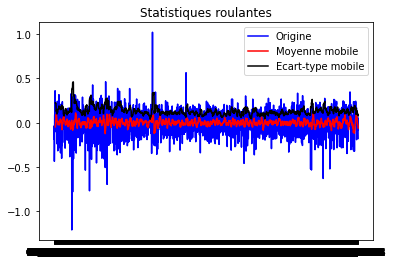

Statistiques ADF : -12.96405926023103
p-value : 3.180708262787129e-24
Valeurs Critiques :
	1%: -3.4334559207180577
	5%: -2.8629120671487107
	10%: -2.5675004234073504


In [16]:
rolling_mean1 = crime_date_log.rolling(window=12).mean()

crime_date_log_minus_mean = crime_date_log - rolling_mean1

crime_date_log_minus_mean.dropna(inplace=True)

get_stationarity(crime_date_log_minus_mean)

On constate que l'original est plus stationnaire que la soustraction de la moyenne mobile

# ARIMA avec un Modèle Auto Regressif d'ordre 2

In [18]:
decomposition = seasonal_decompose(crime_date_log)
model = ARIMA(crime_date_log, order = (2,1,2))
results = model.fit(disp=-1)
plt.plot(crime_date_log)
plt.plot(results.fittedvalues, color='red')
 

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None